<a href="https://colab.research.google.com/github/Lalman888/cnn-pneumonia/blob/main/Pneumonia_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T081951Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2b16204874b17b37530a135abefe3d15fb3d9544ed8339e662e07a169e9e0835785ffa6ddb2a67990f40fd59d9c2fd8caf3e2d69ca6584e3f31903b93514415027bc4495e567f4c3d20d37960f98050658cf964511457dbebbf171ec8e72c5983488e46a0653976d43205ee42bd53c741c4dd74f69b9ba7aa311fc4a30dbe49bc209b600d818f305595a1775474e0c487a34d500d1eb6f627e1e1a1bfb4195b9d0ff3941d3a3230ceaeee2df32c78e32dff1742131ba27e271721589bc385916fb0030d1feacf76ccd5386b43b927cfb03289360f647e7cdbe17c9aa7b1591fc242d9c17e06d6b1d227f08f3f672e0f0beb35c0a3eb4f4b7daa4974c27c3bee2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
Data source import complete.


# Import libraries

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Read&load data..

In [ ]:
train_direct="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
labels = ['NORMAL','PNEUMONIA']
print(os.listdir(train_direct))

['NORMAL', 'PNEUMONIA']


In [ ]:
train_normal=os.path.join(train_direct,"NORMAL")
train_pneumonia=os.path.join(train_direct,"PNEUMONIA")
print("no.PNEUMONIA:" , len(os.listdir(train_pneumonia)))
print("no.NORMAL:" , len(os.listdir(train_normal)))

no.PNEUMONIA: 3875
no.NORMAL: 1341


In [ ]:
sample_normal=os.listdir(train_normal) [0]
sample_pneumonia=os.listdir(train_pneumonia) [0]


Normal example-->>


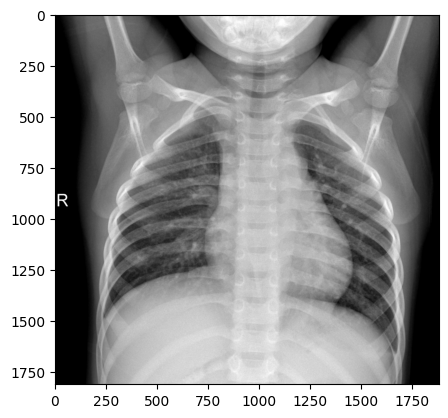

In [ ]:
normal_image=os.path.join(train_normal,sample_normal)
img = cv2.imread(normal_image)
print("Normal example-->>")
plt.imshow(img)

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(1812, 1882, 3)

Pneumonia image-->>


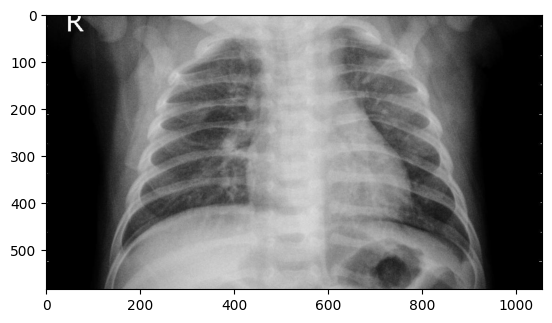

In [ ]:
Pneumonia_image=os.path.join(train_pneumonia,sample_pneumonia)
img=cv2.imread(Pneumonia_image)
print("Pneumonia image-->>")
plt.imshow(img)

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(584, 1056, 3)

# split data into target & data

In [ ]:
data =[]
target=[]
for i in labels:
    path=os.path.join(train_direct,i)
    for img in os.listdir(path):
        one_image=cv2.imread(os.path.join(path,img))
        if one_image is not None:
            resize_img=cv2.resize(one_image,(128,128))
            data.append(resize_img)
            target.append(labels.index(i))


In [ ]:
type(data)

list

In [ ]:
type(target)

list

In [ ]:
data=np.array(data)
target=np.array(target)
type(target),type(data)

(numpy.ndarray, numpy.ndarray)

In [ ]:
data.shape,target.shape

((5216, 128, 128, 3), (5216,))

In [ ]:
data_flat=data.reshape(data.shape[0],-1)

# Support vector machine

split data svm

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data_flat,target,test_size=0.2,random_state=42)

train svm

In [ ]:
model = SVC(max_iter=10000)
model.fit(x_train,y_train)

SVC(max_iter=10000)

valid svm

In [ ]:
import joblib
joblib.dump(model, 'svm_model2.pkl')

['svm_model2.pkl']

In [ ]:
from sklearn.metrics import accuracy_score
y_pre=model.predict(x_test)


In [ ]:
accuracy=accuracy_score(y_test,y_pre)
print("accuracy:",accuracy*100 ,"%")

accuracy: 96.64750957854406 %


# SVM whit PCA

In [ ]:
pca=PCA(0.95)
data_pca=pca.fit_transform(data_flat)

In [ ]:
x_train_pca,x_test_pca,y_train_pca,y_test_pca=train_test_split(data_pca,target,test_size=0.2,random_state=42)

In [ ]:
model_pca = SVC(max_iter=10000)
model_pca.fit(x_train_pca, y_train_pca)

SVC(max_iter=10000)

In [ ]:
from sklearn.metrics import accuracy_score
y_pre=model_pca.predict(x_test_pca)


In [ ]:
accuracy=accuracy_score(y_test,y_pre)
print("accuracy:",accuracy*100 ,"%")

accuracy: 97.22222222222221 %


In [ ]:
import joblib
joblib.dump(model_pca, 'svm_modelpca.pkl')

['svm_modelpca.pkl']

In [ ]:
joblib.dump(model_pca, 'svm_modelpca_h.h5')

['svm_modelpca_h.h5']

# NN(Neural Network)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.models import Sequential


In [ ]:
model_NN=Sequential([
    Conv2D(64,(3,3),activation="relu",input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation="relu",),
    MaxPooling2D((2,2)),


])
model_NN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,720 (151.25 KB)

 Trainable params: 38,720 (151.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_NN.add(Flatten())
model_NN.add(Dense(255, activation="relu"))
model_NN.add(Dense(128, activation="relu"))
model_NN.add(Dense(128, activation="relu"))
model_NN.add(Dense(64, activation="relu"))
model_NN.add(Dense(64, activation="relu"))
model_NN.add(Dense(64, activation="relu"))
model_NN.add(Dense(32, activation="relu"))
model_NN.add(Dense(16, activation="relu"))
model_NN.add(Dense(1, activation="sigmoid"))

model_NN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 255)                 │      14,688,255 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,795,456 (56.44 MB)

 Trainable params: 14,795,456 (56.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.3,random_state=42)

In [ ]:
model_NN.fit(x_train, y_train, epochs=10, batch_size=8)

Epoch 1/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7973 - loss: 0.7291
Epoch 2/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8929 - loss: 0.3253
Epoch 3/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9101 - loss: 0.2234
Epoch 4/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8969 - loss: 0.2521
Epoch 5/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9369 - loss: 0.1931
Epoch 6/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9438 - loss: 0.1504
Epoch 7/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9383 - loss: 0.1734
Epoch 8/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9636 - loss: 0.1146
Epoch 9/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9251 - loss: 0.2742
Epoch 10/10
457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8864 - loss: 0.3343


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model_NN.evaluate(x_test, y_test)

# Print the accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9278 - loss: 0.2130
Test Accuracy: 93.48%


In [ ]:
# Testing the model with an image from a file path
def predict_image_from_path(model, image_path):
    # Load the image
    img = cv2.imread(image_path)
    # Preprocess the image
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1]

    # Make a prediction
    prediction = model.predict(img)

    # Define the labels
    labels = ['NORMAL', 'PNEUMONIA']

    # Determine the class
    predicted_class = labels[int(prediction[0] > 0.5)]

    return predicted_class

# Example usage
image_path = '/content/0a1f5edc85aa58d5780928cb39b08659c1fc4d6d7c7dce2f8db1d63c7c737234_big_gallery.jpeg'  # Replace with your image path
predicted_class = predict_image_from_path(model_NN, image_path)
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Predicted class: PNEUMONIA


<ipython-input-54-a2c73dcec30b>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = labels[int(prediction[0] > 0.5)]


In [ ]:
tensorflow_version = tf.__version__.replace('.', '_')
model_save_path = f'cnn_pneumonia_model_tf{tensorflow_version}.keras'
model_NN.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: cnn_pneumonia_model_tf2_17_0.keras
